# Data Analytics with JS

The dataset contains all the information about cars, a name of a manufacturer, all car's technical parameters and a sale price of a car.

Libraries:
 - nodejs-polars
 - @observable/plot

## Exploring Data

Use [pola-rs](https://pola-rs.github.io/nodejs-polars/modules.html) dataframes to read and manipulate data.

- use `df.head(n)` to get n first rows
- use `df.sample(n)` to get n random rows from the dataset
- use `df.describe()` to get mean, std, min, max
- use `df.select(...cols)` to get new dataframe for columns
- use `df.groupBy(..cols).agg()` to group data and get aggragates

In [1]:
import { display } from "https://deno.land/x/display@v0.1.1/mod.ts"
import pl from "npm:nodejs-polars"

let data = await Deno.readTextFile('assets/CarPrice_Assignment.csv')
let df = pl.readCSV(data, { sep: "," })

await display(df.head(5))

car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9,154,5000,19,26,16500
4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.4,10,102,5500,24,30,13950
5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.4,8,115,5500,18,22,17450


In [2]:
await display(
    df.select(
        'enginesize', 
        'horsepower', 
        'price'
    ).describe()
)

describe,enginesize,horsepower,price
mean,126.90731707317073,104.1170731707317,13276.710570731706
std,41.642693438179855,39.54416680936116,7988.852331743148
min,61,48,5118
max,326,288,45400
median,120,95,10295


## Data Cleaning

In [3]:
// check for duplicates
const hasDups = df.select('car_ID').isDuplicated().toArray().includes(true)
// if there are duplicates, use df.filter()
hasDups

false

Resolve categorical values. For this dataset it is a brand name:

In [4]:
// get brand names from `CarName`
let brandNameTable = df.select('CarName').map((row) => {
    const [carName] = row
    const brand = carName.split(' ')[0].toLowerCase()
    return brand
})

// create a dataframe from brand names
let brandDf = pl.DataFrame({
    "brand": brandNameTable
})
await display(brandDf.unique())

brand
peugeot
bmw
buick
porcshce
volvo
maxda
renault
mazda
alfa-romero
subaru


In [5]:
// transform to remove duplicates
brandNameTable = brandNameTable.map((name) => {
    name = name
            .replace('maxda', 'mazda')
            .replace('porcshce', 'porsche')
            .replace('toyouta', 'toyota')
            .replace(/(vw|vokswagen)/ig, 'volkswagen');
    return name
})

brandDf = pl.DataFrame({
    brand: brandNameTable
})
await display(brandDf.unique())

brand
plymouth
mitsubishi
dodge
jaguar
mercury
honda
subaru
chevrolet
nissan
mazda


In [6]:
// add new column `brand` to our dataframe
df = brandDf.hstack(df)
await display(df.head(5))

brand,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
alfa-romero,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
alfa-romero,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
alfa-romero,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9,154,5000,19,26,16500
audi,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.4,10,102,5500,24,30,13950
audi,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.4,8,115,5500,18,22,17450


Drop unnecessary values, and write to the new file:

In [7]:
df = df.drop('car_ID', 'symboling', 'CarName')
df.head(3)

brand,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9,154,5000,19,26,16500


- Use df.groupBy(...cols) in order to get aggregates form the dataset:

Count cars by brand:

In [8]:
let brandCount = df.groupBy('brand').len().sort('brand_count')
brandCount

brand,brand_count
mercury,1
renault,2
chevrolet,3
alfa-romero,3
jaguar,3
isuzu,4
porsche,5
saab,6
audi,7
plymouth,7


In [9]:
let avgPricePerBrand = df.groupBy('brand').agg({'price': ['mean']})
avgPricePerBrand.describe()

describe,brand,price
mean,null,15079.87737191671
std,null,8738.804703803095
min,alfa-romero,6007
max,volvo,34600
median,null,10534.274509803921


In [10]:
// map brand name to price
avgPricePerBrand = avgPricePerBrand
    .toRecords()
    .reduce((acc, rec) => ({...acc, [rec.brand]: rec.price}), {})

{
  jaguar: 34600,
  subaru: 8541.25,
  buick: 33647,
  audi: 17859.166714285715,
  mitsubishi: 9239.76923076923,
  mazda: 10652.882352941177,
  dodge: 7875.444444444444,
  peugeot: 15489.09090909091,
  volkswagen: 10077.5,
  renault: 9595,
  honda: 8184.692307692308,
  "alfa-romero": 15498.333333333334,
  saab: 15223.333333333334,
  bmw: 26118.75,
  isuzu: 8916.5,
  porsche: 31400.5,
  nissan: 10415.666666666666,
  volvo: 18063.18181818182,
  toyota: 9885.8125,
  chevrolet: 6007,
  mercury: 16503,
  plymouth: 7963.428571428572
}

In [11]:
// create brand categories by budget
let brandCategory = df.brand.toArray().map((brand) => {
    const avgPrice = avgPricePerBrand[brand]
    return avgPrice < 10000 ? "Budget" : avgPrice > 20000 ? "Luxury" : "Mid_Range"
})
let catDf = pl.DataFrame({
    "brand_category": brandCategory
})

catDf.sample(5)

brand_category
Budget
Mid_Range
Mid_Range
Luxury
Budget


Write the cleaned dataset to a new file:

In [12]:
df = catDf.hstack(df)
df.writeCSV('assets/cleaned_car_prices.csv')

## Exploratory Data Analysis

For plotting we use [@observable/plot](https://observablehq.com/plot) and configured shotcuts for jupyter notebooks imported from [l12.xyz/x/shortcuts](https://l12.xyz/x/shortcuts).

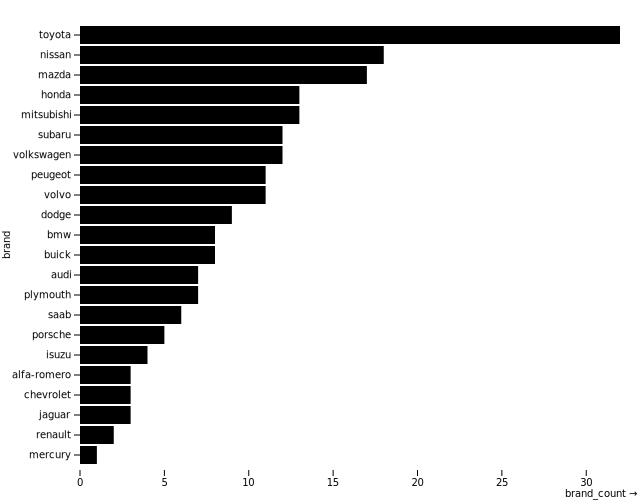

In [13]:
import {Plot, document} from 'https://l12.xyz/x/shortcuts/raw/branch/main/plots.ts?95'

const brandCountRecords = brandCount.toRecords()

const brandCountPlot = Plot.plot({
    marginLeft: 80,
    style: {
        backgroundColor: "#fff"
    },
    x: {padding: 0.4},
    marks: [
        Plot.barX(brandCountRecords, {x: "brand_count", y: "brand", sort: {y: "x", order: "descending"}}),
    ],
    document
})
await display(brandCountPlot)

In [14]:
let numericColumns = df.columns.filter((col) => df[col].isNumeric() && col !== 'price')
numericColumns

[
  "wheelbase",        "carlength",
  "carwidth",         "carheight",
  "curbweight",       "enginesize",
  "boreratio",        "stroke",
  "compressionratio", "horsepower",
  "peakrpm",          "citympg",
  "highwaympg"
]

Sometimes we can get some intuitive insight seeing the data plotted from different dimensions. It is an optional step, but it might help to get some assumtions about the relationships in the dataset. Below is an example for drawing plots side-by-side.

In [15]:
import { sideBySidePlot } from 'https://l12.xyz/x/shortcuts/raw/plots.ts?95'

let records = df.toRecords();

const plt = sideBySidePlot({
    x: numericColumns,
    y: ['price'],
    marks: [
        (x, y) => Plot.dot(records, {x, y}),
        (x, y) => Plot.linearRegressionY(records, {x, y, stroke: "red"}),
    ],
    cols: 3
})

await display(
    plt,
);

Let's view the list of top features that have high correlation coefficient. The pearsonCorr() function calculates the Pearson'r correlation coefficients with respect to the 'price'.

In [16]:
// we select pearon's idx from dataframe for all numeric cols, 
// then we transpose result so that columns become rows, 
// then we sort by the idx column
df.select(
    ...numericColumns.map((col) => pl.pearsonCorr(col, 'price'))
)
    .transpose({
        columnNames: ["idx (price)"],
        headerName: "Variable",
        includeHeader: true
    })
    .sort('idx (price)', true)

Variable,idx (price)
enginesize,0.8741448025245117
curbweight,0.8353048793372955
horsepower,0.8081388225362217
carwidth,0.7593252997414263
carlength,0.6829200156779843
wheelbase,0.5778155982921477
boreratio,0.5531732367984261
carheight,0.11933622657047727
stroke,0.07944308388192935
compressionratio,0.06798350579944248


### Linearity Assumption

Linear regression needs the relationship between independent variable and the dependent variable to be linear. We can test this assumption with some scatter plots and regression lines.

** Here we use the same side-by-side plot shortcut, but for selected varisbles with high correlation coefficent.


In [17]:
const plt = sideBySidePlot({
    x: ['enginesize', 'curbweight', 'horsepower', 'carwidth'],
    y: ['price'],
    marks: [
        (x, y) => Plot.dot(records, {x, y}),
        (x, y) => Plot.linearRegressionY(records, {x, y, stroke: "red"}),
    ],
    cols: 2
})

await display(
    plt,
);

### Homoscedasticity

The assumption of homoscedasticity (constant variance), is crucial to linear regression models. Homoscedasticity describes a situation in which the error term or variance or the "noise" or random disturbance in the relationship between the independent variables and the dependent variable is the same across all values of the independent variable. In other words, there is a constant variance present in the response variable as the predictor variable increases. If the "noise" is not the same across the values of an independent variable, we call it heteroscedasticity, opposite of homoscedasticity. 

#### Residuals

Next we apply residual expression to 'price' and 'enginesize' varibles in order to check this assumption.
[The residuals function](https://l12.xyz/x/shortcuts/src/branch/main/expr.ts) uses mean squared.

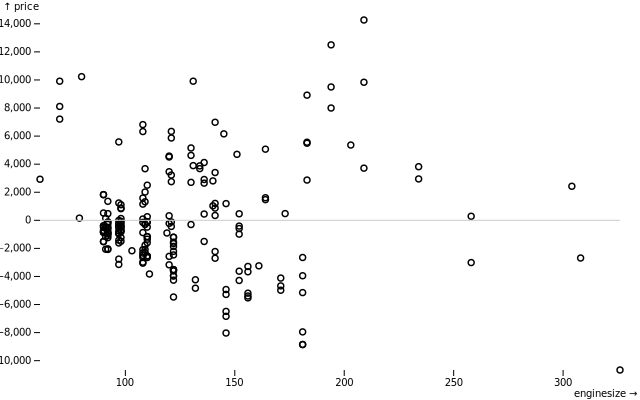

In [18]:
import { residuals } from 'https://l12.xyz/x/shortcuts/raw/expr.ts'

let residualDf = df.select(
    'enginesize', 
    residuals(pl.col('enginesize'), pl.col('price'))
)

let residPlot = Plot.plot({
    x: "enginesize", 
    y: "price",
    marks: [
        Plot.dot(residualDf.toRecords(), { x: "enginesize", y: "price"}),
        Plot.ruleY([0], {stroke: '#ccc'})
    ],
    document
})

await display(residPlot)


From the above plot, we can tell the error variance across the true line is dispersed somewhat not uniformly, but in a funnel like shape. So, the assumption of the *homoscedasticity* is more likely not met.


## Normality

The linear regression analysis requires the dependent variable, 'price', to be normally distributed. A histogram, box plot, or a Q-Q-Plot can check if the target variable is normally distributed. The goodness of fit test, e.g., the Kolmogorov-Smirnov test can check for normality in the dependent variable. [This documentation](https://towardsdatascience.com/normality-tests-in-python-31e04aa4f411) contains more information on the normality assumption. 

Let's display all three charts to show how our target variable, 'price' behaves.

In [19]:
import { threeChart } from './plots.ts?15'

await display(threeChart(records, "price"))

These three charts above can tell us a lot about our target variable:

- Our target variable, 'price' is not normally distributed
- Our target variable is right-skewed
- There are some outliers in the variable

The right-skewed plot means that most prices in the dataset are on the lower end (below 15,000). The 'max' value is very far from the '75%' quantile statistic. All these plots show that the assumption for accurate linear regression modeling is not met. 

Next, we will perform the log transformation to correct our target variable and to make it more normally distributed.

In [20]:
import {ShapiroWilkW} from "./normality.ts?18"

ShapiroWilkW(df.price.sort())

0.8006648595531076

In [21]:
let log2df = df.select(pl.col("price").log())

await display(threeChart(log2df.toRecords(), "price"))

In [22]:
ShapiroWilkW(log2df.price.sort())

0.948674582545282

## Data Encoding

In [23]:
let carData = pl.readCSV(
    await Deno.readTextFile('assets/cleaned_car_prices.csv'),
    { sep: "," }
)

carData.head(5)

brand_category,brand,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
Mid_Range,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
Mid_Range,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
Mid_Range,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9,154,5000,19,26,16500
Mid_Range,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.4,10,102,5500,24,30,13950
Mid_Range,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.4,8,115,5500,18,22,17450


We'll drop some unnecessary columns:

In [24]:
let carDataGeneralized = carData.drop('brand', 'carbody', 'enginelocation', 'stroke', 'compressionratio', 'peakrpm')
carDataGeneralized.head(5)

brand_category,fueltype,aspiration,doornumber,drivewheel,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,horsepower,citympg,highwaympg,price
Mid_Range,gas,std,two,rwd,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,111,21,27,13495
Mid_Range,gas,std,two,rwd,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,111,21,27,16500
Mid_Range,gas,std,two,rwd,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,154,19,26,16500
Mid_Range,gas,std,four,fwd,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,102,24,30,13950
Mid_Range,gas,std,four,4wd,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,115,18,22,17450


Next we use one hot (binary) encoding. We assume that all non-numeric colums are categorical.

In [25]:
import { oneHotEncoding } from './encoding.ts?6'

let encodedCarData = oneHotEncoding(carDataGeneralized)
encodedCarData.head(5)

brand_category_Budget,brand_category_Luxury,brand_category_Mid_Range,fueltype_diesel,fueltype_gas,aspiration_std,aspiration_turbo,doornumber_four,doornumber_two,drivewheel_4wd,drivewheel_fwd,drivewheel_rwd,wheelbase,carlength,carwidth,carheight,curbweight,enginetype_dohc,enginetype_dohcv,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,cylindernumber_eight,cylindernumber_five,cylindernumber_four,cylindernumber_six,cylindernumber_three,cylindernumber_twelve,cylindernumber_two,enginesize,fuelsystem_1bbl,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi,boreratio,horsepower,citympg,highwaympg,price
0,0,1,0,1,1,0,0,1,0,0,1,88.6,168.8,64.1,48.8,2548,1,0,0,0,0,0,0,0,0,1,0,0,0,0,130,0,0,0,0,0,1,0,0,3.47,111,21,27,13495
0,0,1,0,1,1,0,0,1,0,0,1,88.6,168.8,64.1,48.8,2548,1,0,0,0,0,0,0,0,0,1,0,0,0,0,130,0,0,0,0,0,1,0,0,3.47,111,21,27,16500
0,0,1,0,1,1,0,0,1,0,0,1,94.5,171.2,65.5,52.4,2823,0,0,0,0,0,1,0,0,0,0,1,0,0,0,152,0,0,0,0,0,1,0,0,2.68,154,19,26,16500
0,0,1,0,1,1,0,1,0,0,1,0,99.8,176.6,66.2,54.3,2337,0,0,0,1,0,0,0,0,0,1,0,0,0,0,109,0,0,0,0,0,1,0,0,3.19,102,24,30,13950
0,0,1,0,1,1,0,1,0,1,0,0,99.4,176.6,66.4,54.3,2824,0,0,0,1,0,0,0,0,1,0,0,0,0,0,136,0,0,0,0,0,1,0,0,3.19,115,18,22,17450


In [26]:
encodedCarData.writeCSV('assets/encoded_car_data.csv')